# Simulations for determining best values of $\lambda$

In [1]:
import numpy
import os

import helpers
import matplotlib

import astropy
from astropy.io import fits

from scipy import signal

from visibilities import *
from rascil.processing_components import export_visibility_to_ms

matplotlib.pyplot.set_loglevel("critical")

cmap = 'viridis'
matplotlib.rcParams['figure.figsize'] = [10, 5]

## 3 Ground Truth Images (without noise), taken from Meerkat survey, edges cut and feathered to reduce what appears to be artefacting from nifty

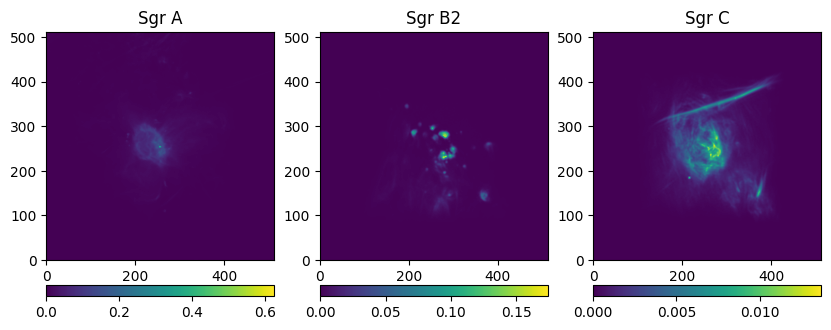

In [2]:
sgra = helpers.readFits("data/SGRA_full_gt.fits")
sgrb = helpers.readFits("data/SGRB_full_gt.fits")
sgrc = helpers.readFits("data/SGRC_full_gt.fits")

helpers.plotNImages([sgra, sgrb, sgrc], ["Sgr A", "Sgr B2", "Sgr C"], cmap)

In [3]:
phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-30.0 * u.deg, frame='icrs', equinox='J2000')
ha_interval=(-2,2)
vt = generate_visibilities(phasecentre,ha_interval,tel="MEERKAT", integration_time=120)
vt, cell_size, im = visibilities_from_image(vt,'data/badly_centered.fits',return_cellsize=True,return_image=True,scale_factor=3)
#export_visibility_to_ms('data/badly_centered.ms',[vt])
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512,weighting="uniform")

dirty = dirty.pixels.data
while len(dirty.shape) > 2:
    dirty = dirty[0]
    
psf = psf.pixels.data
while len(psf.shape) > 2:
    psf = psf[0]
    
gt = helpers.readFits("data/badly_centered.fits")
while len(gt.shape) > 2:
    gt = gt[0]

nifty = dirty
circular = helpers.circularConv(gt, psf)
linear = helpers.linearConv(gt, psf)
linearscipy = helpers.linearConvScipy(gt, psf)

wsclean = helpers.readFits("badly_centered_wsclean.fits")
wsclean_nifty = helpers.readFits("badly_centered_wsclean_nifty.fits")

create_named_configuration: MEERKAT
	(<Quantity 5109360.08350152 m>, <Quantity 2006852.56658911 m>, <Quantity -3238948.21751511 m>)
	GeodeticLocation(lon=<Longitude 21.44388889 deg>, lat=<Latitude -30.7110565 deg>, height=<Quantity 1086.6 m>)
create_configuration_from_file: 64 antennas/stations
create_visibility: created 120 times
create_visibility: 249600 rows, 0.013 GB
advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10597.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
ad

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 3.08242e-05 radians, 0.0017661 degrees
create_image_from_visibility: Resetting cellsize 3.08242e-05 radians to criticalcellsize 2.05495e-05 radians
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 4.238631e+00
warning visibility_weight_to_griddata gridding: skipped 14 visbility


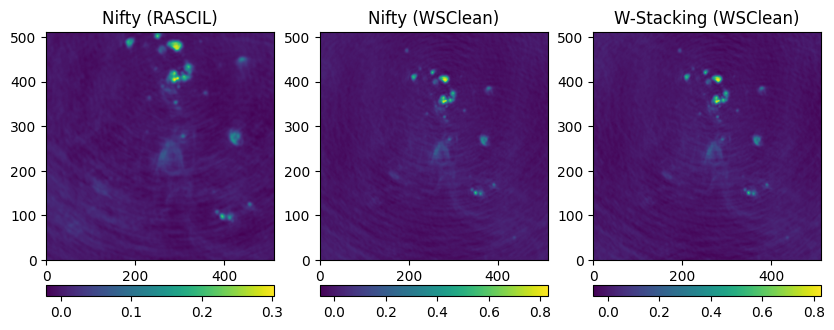

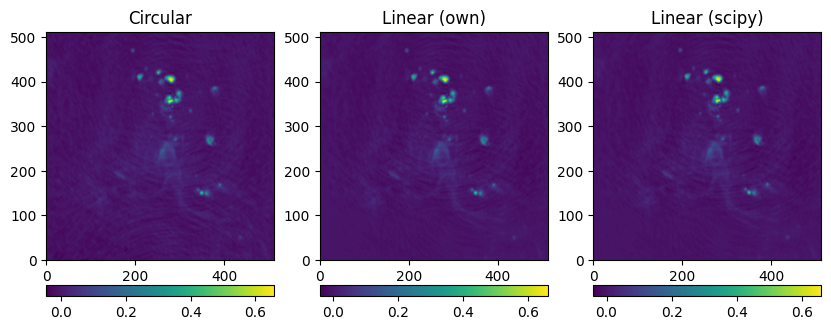

0.65959290057786


In [4]:
#helpers.write_nparr_to_fits(nifty, "sgra_nifty_dirty.fits")

helpers.plotNImages([nifty, wsclean_nifty, wsclean], ["Nifty (RASCIL)", "Nifty (WSClean)", "W-Stacking (WSClean)"], cmap)
helpers.plotNImages([circular, linear, linearscipy], ["Circular", "Linear (own)", "Linear (scipy)"], cmap)

print(numpy.max(linear))

## Determine number of sample points. Use exponential curve instead of linear to allow for better coverage for lower values of lambda

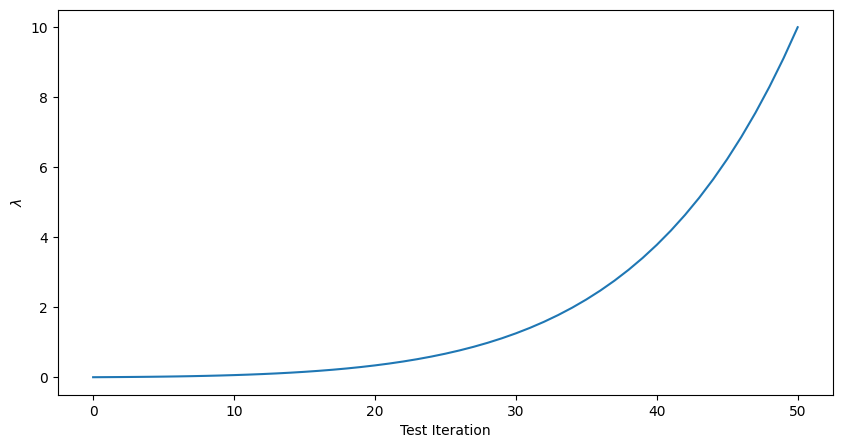

In [5]:
num_samples = 50
lambda_low = 0.001
lambda_high = 10

step = 1 / float(num_samples)

x_vals = numpy.arange(0, 1 + step, step)

lambdas = [0] * len(x_vals)
for i, v in enumerate(x_vals):
    lambdas[i] = helpers.exp_growth(v, lambda_low, lambda_high, steepness = 0.5)
    
helpers.plot1D(range(0, len(lambdas)), lambdas, "Test Iteration", "$\lambda$")

## Test case 1: SGR A full

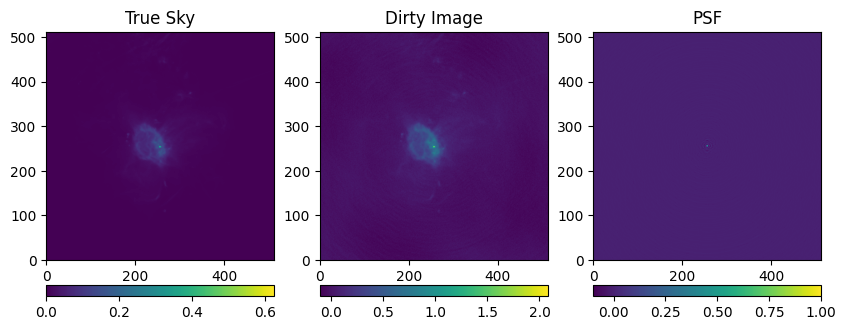

In [6]:
gt = helpers.readFits("lambda_tests/SGRA_full_gt.fits")
dirty = helpers.readFits("lambda_tests/SGRA_full_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRA_full_psf.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRA_full/"

Best Lambda according to SNR: 0.3387054058122328


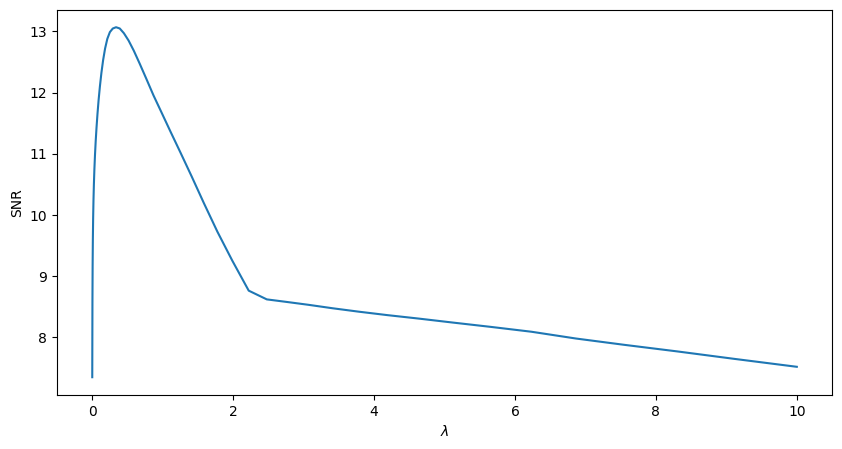

Best Lambda according to SSIM: 0.18312249623636734


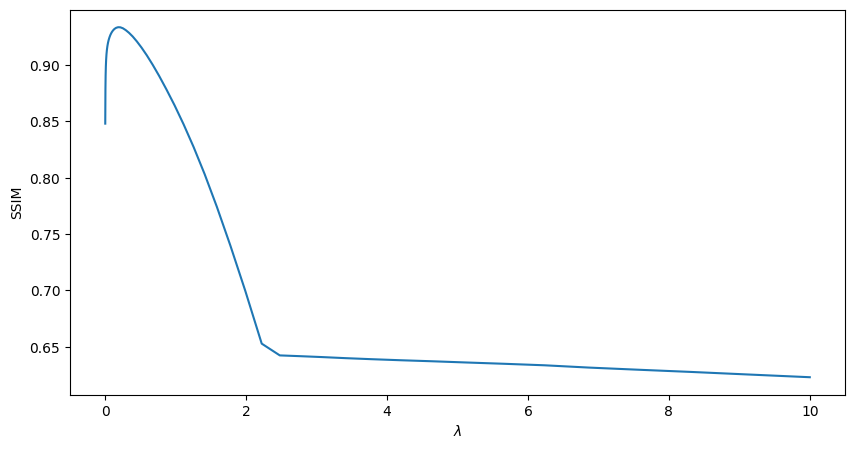

In [7]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda according to SNR: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

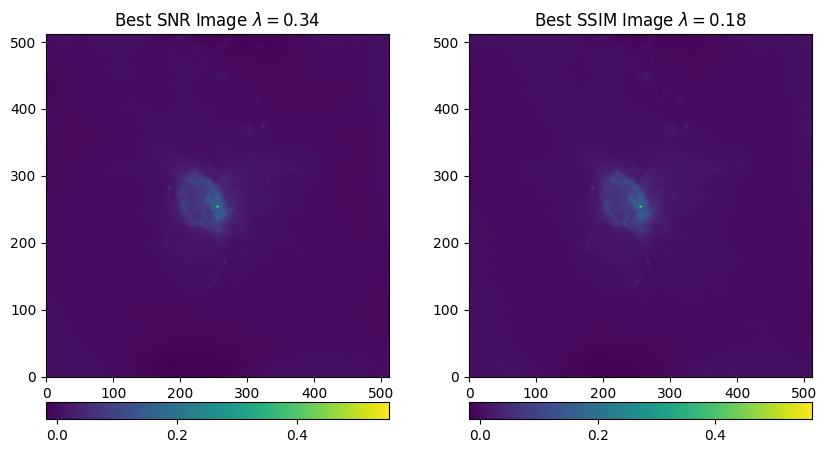

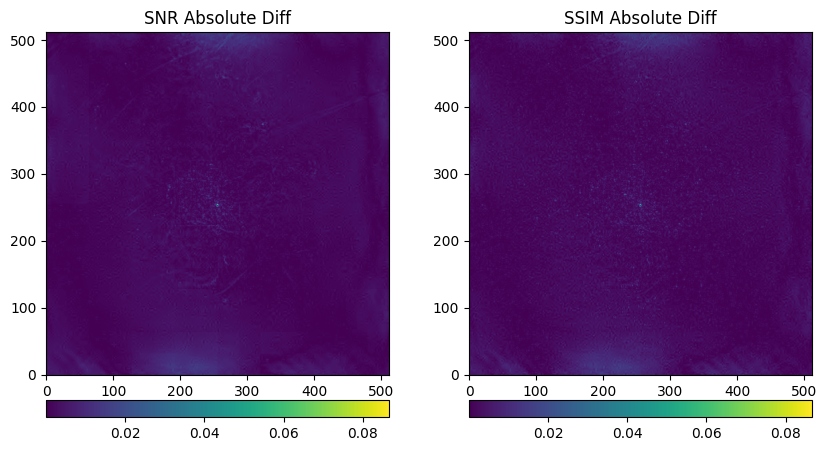

In [8]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 2: SGR B2 full

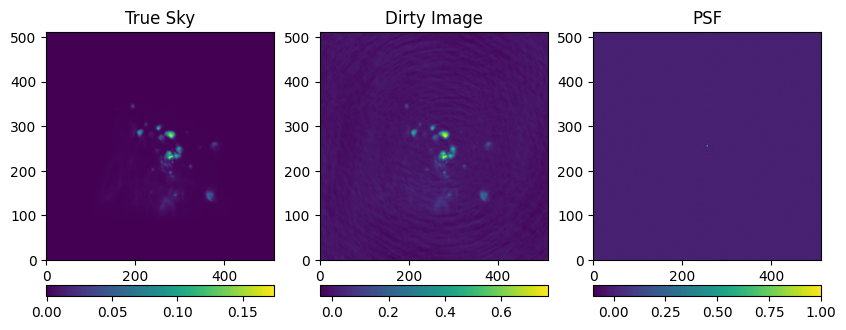

In [9]:
gt = helpers.readFits("lambda_tests/SGRB_full_gt.fits")
dirty = helpers.readFits("lambda_tests/SGRB_full_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRB_full_psf.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRB_full/"

Best Lambda according to SNR: 0.18312249623636734


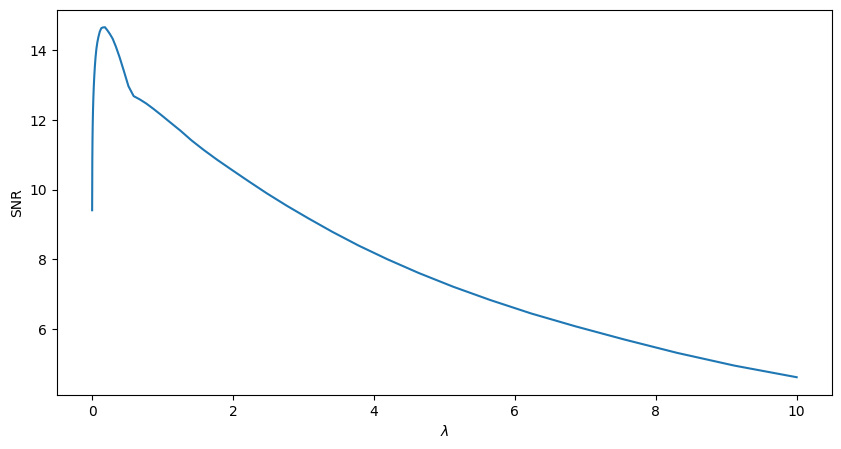

Best Lambda according to SSIM: 0.061497063981206315


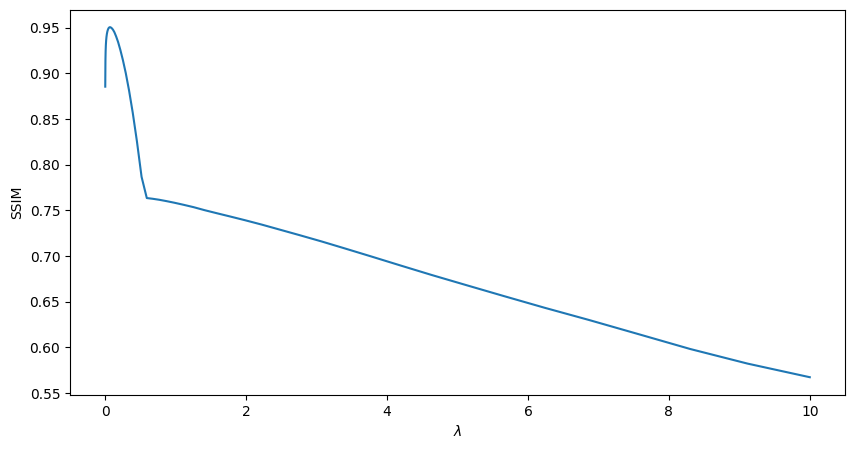

In [10]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda according to SNR: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

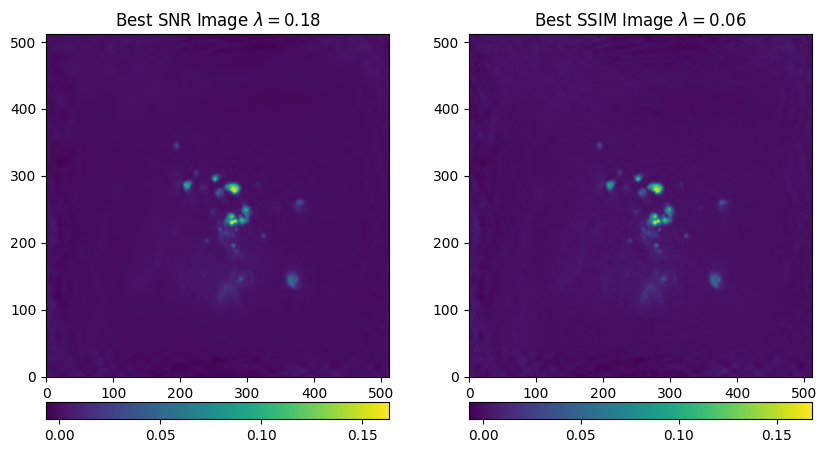

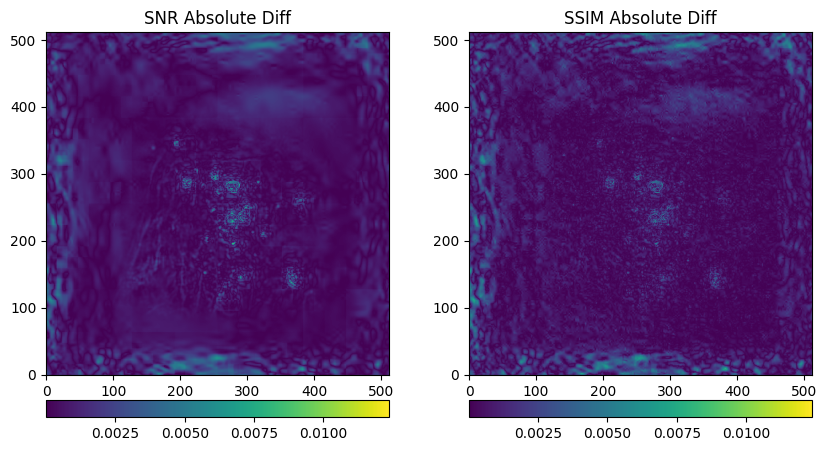

In [11]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 3: SGR C full

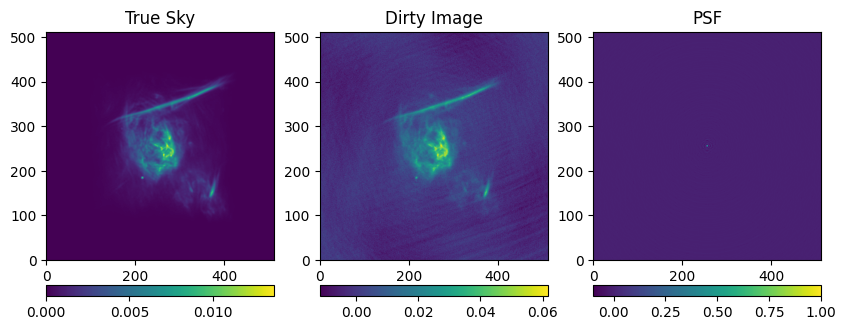

In [12]:
gt = helpers.readFits("lambda_tests/SGRC_full_gt.fits")
dirty = helpers.readFits("lambda_tests/SGRC_full_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRC_full_psf.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRC_full/"

Best Lambda according to SNR: 0.031380723676513914


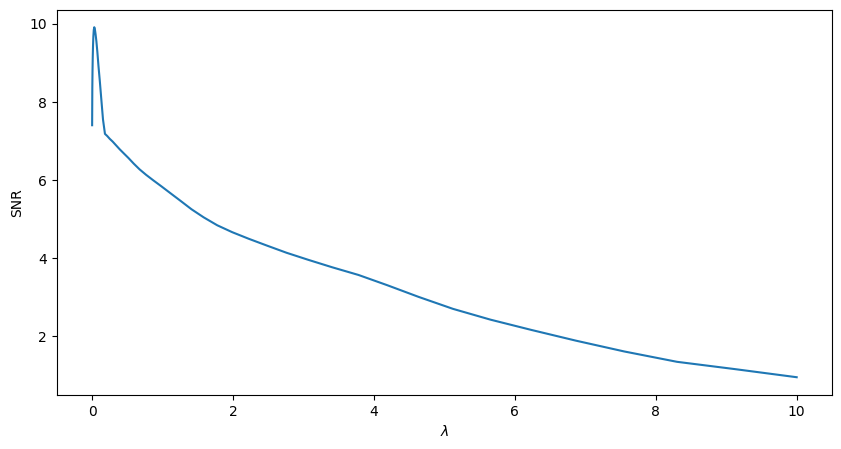

Best Lambda according to SSIM: 0.013532276092231024


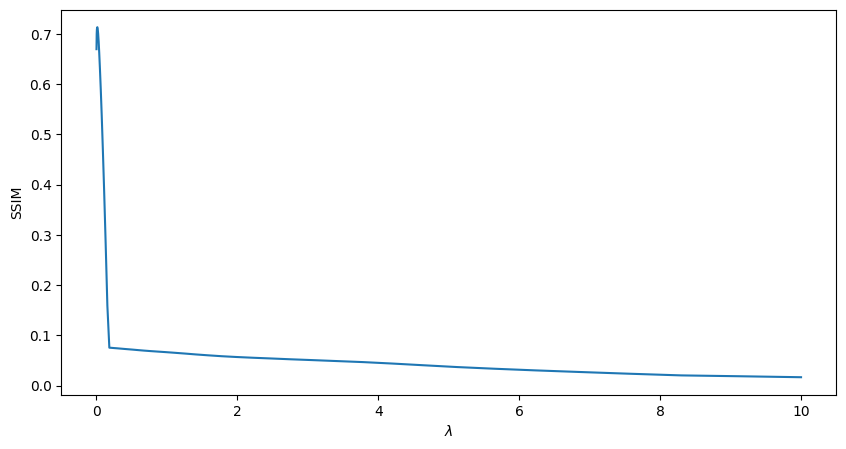

In [13]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda according to SNR: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

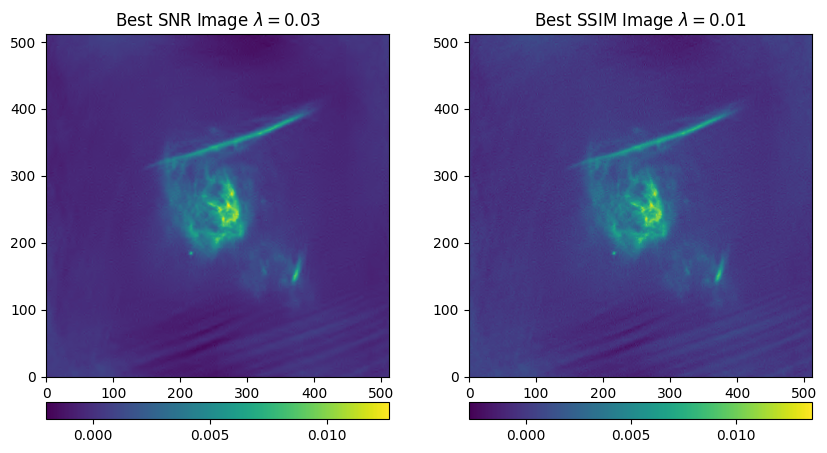

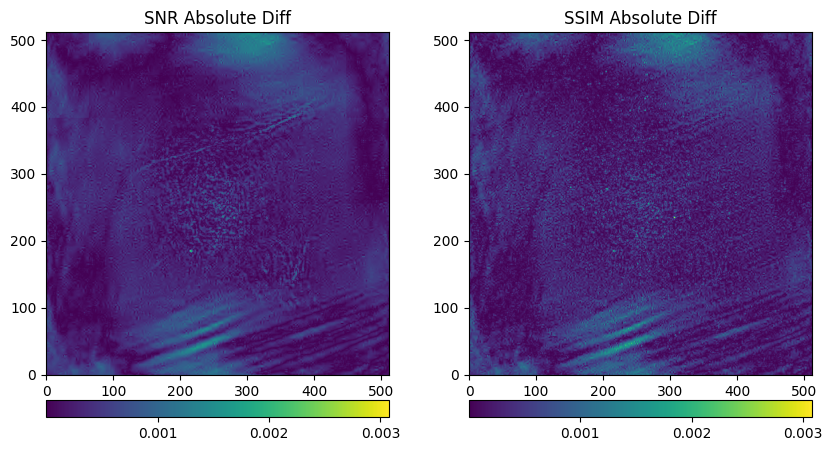

In [14]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 4: SGR A short baselines

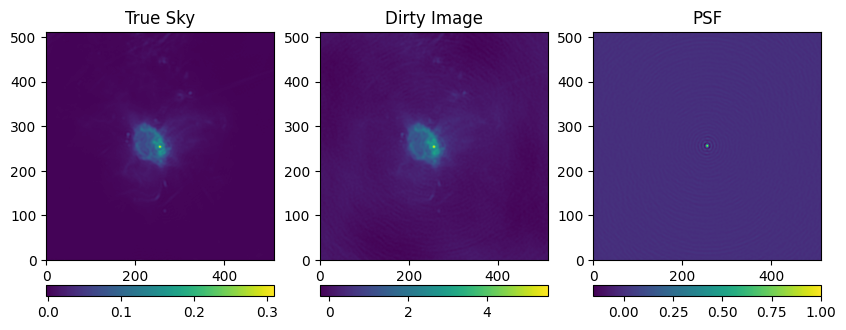

In [15]:
dirty = helpers.readFits("lambda_tests/SGRA_short_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRA_short_psf.fits")
gt = helpers.readFits("lambda_tests/SGRA_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRA_short/"

Best Lambda according to SNR: 6.865390087731918


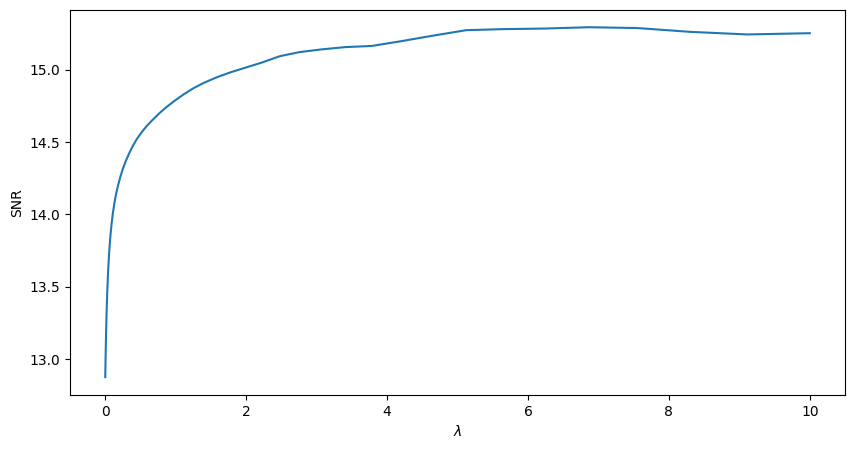

Best Lambda according to SSIM: 0.001


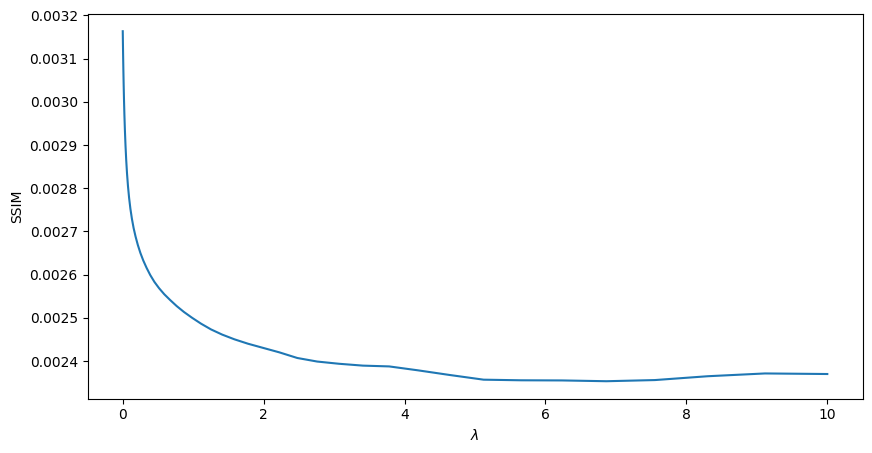

In [16]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda according to SNR: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

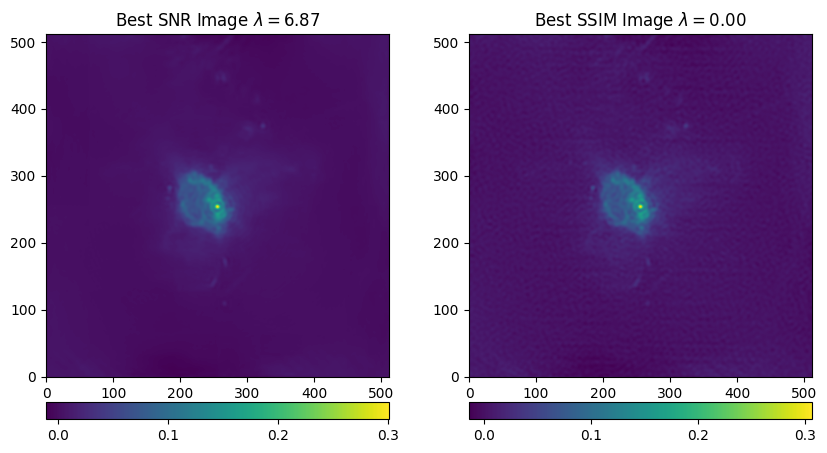

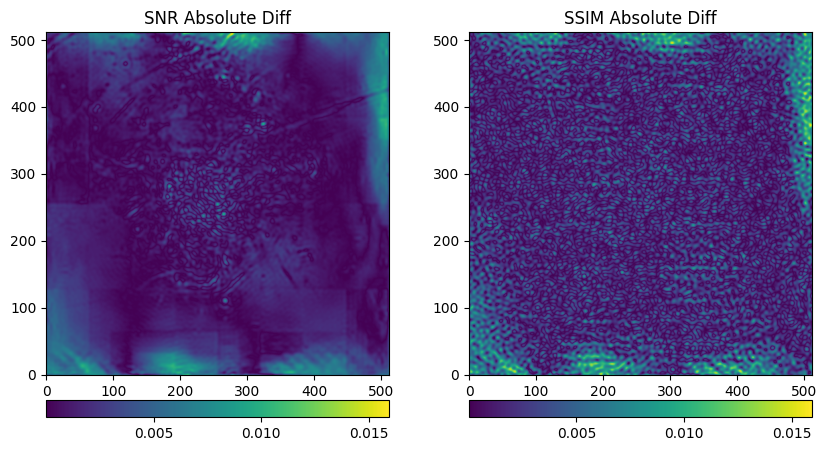

In [17]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 5: SGR B2 short baselines

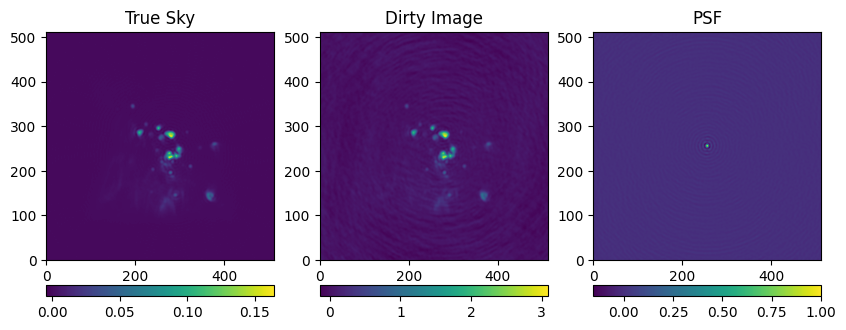

In [18]:
dirty = helpers.readFits("lambda_tests/SGRB_short_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRB_short_psf.fits")
gt = helpers.readFits("lambda_tests/SGRB_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRB_short/"

Best Lambda: 6.865390087731918


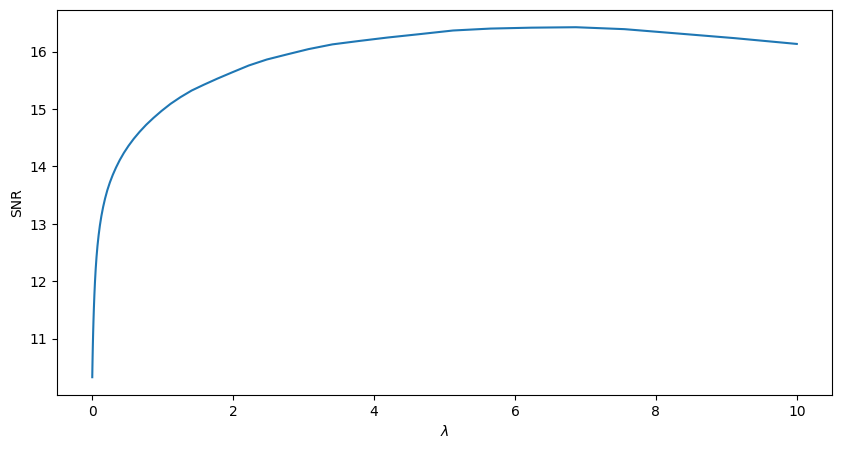

Best Lambda according to SSIM: 0.001


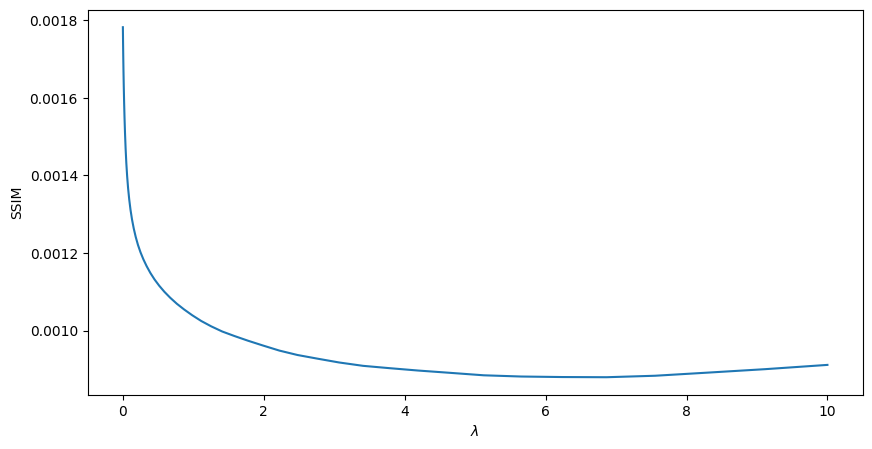

In [19]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

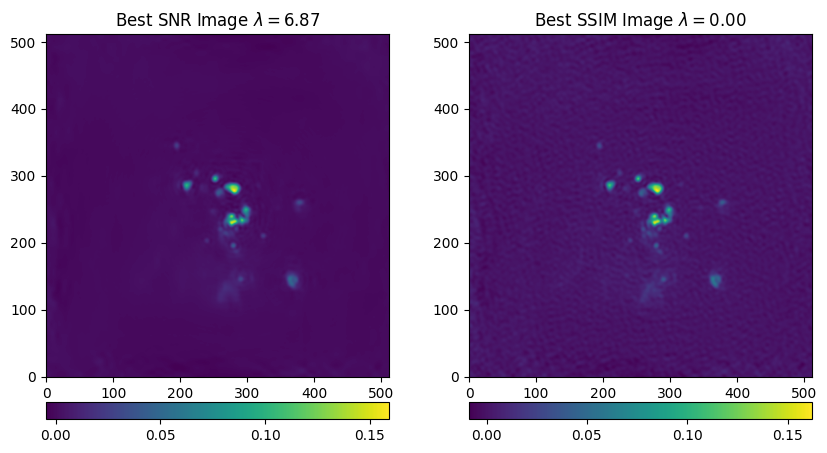

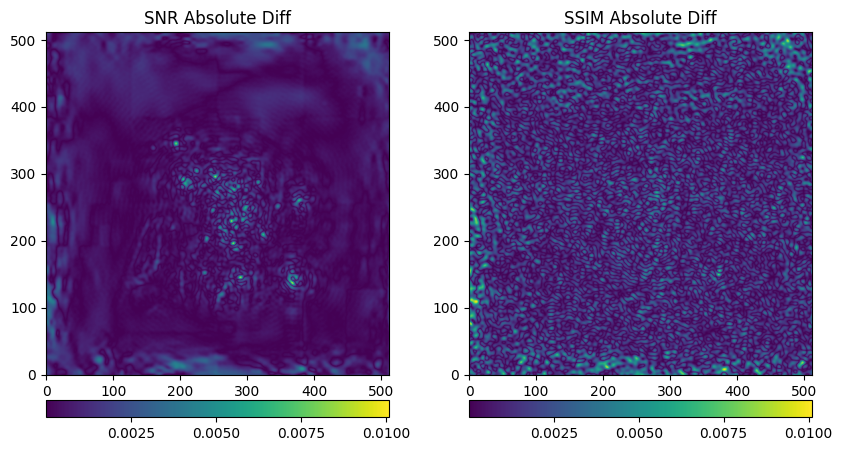

In [20]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 6: SGR C short baselines

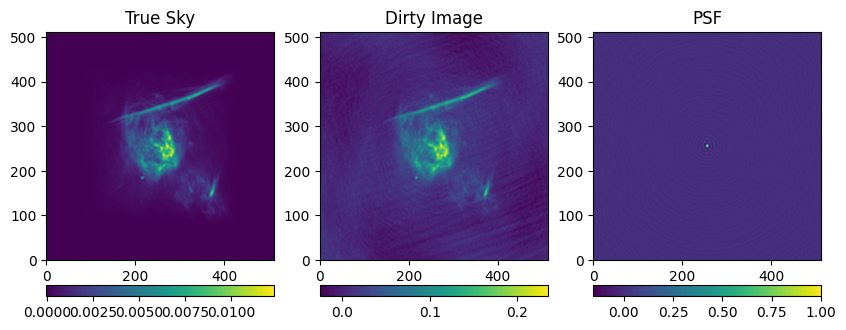

In [21]:
dirty = helpers.readFits("lambda_tests/SGRC_short_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRC_short_psf.fits")
gt = helpers.readFits("lambda_tests/SGRC_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRC_short/"

Best Lambda according to SNR: 1.2542574143310892


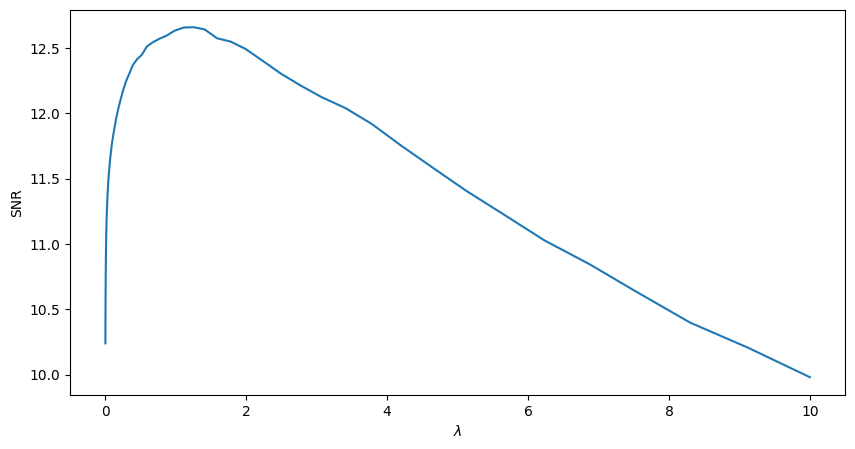

Best Lambda according to SSIM: 10.0


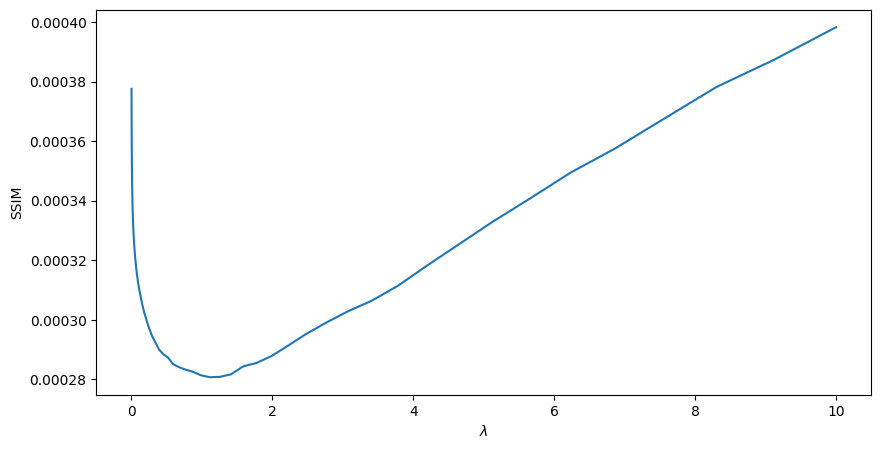

In [22]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda according to SNR: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

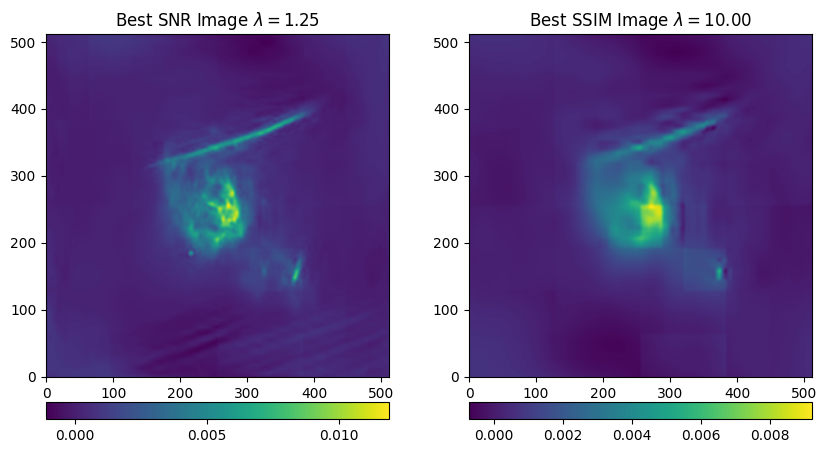

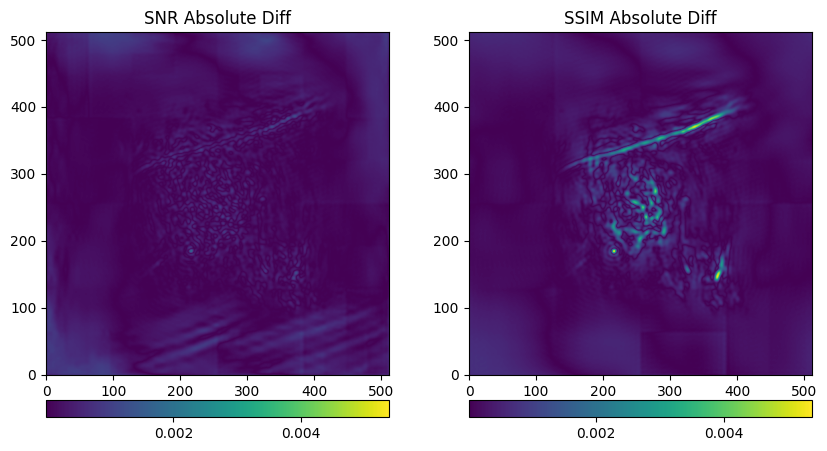

In [23]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 7: SGR A multi-step

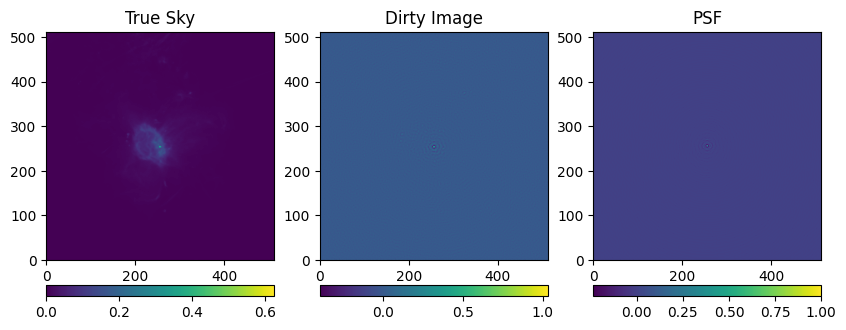

In [24]:
dirty = helpers.readFits("lambda_tests/SGRA_long_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRA_long_psf.fits")
gt = helpers.readFits("lambda_tests/SGRA_full_gt.fits")
lowres = helpers.readFits("lambda_tests/SGRA_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRA_multistep/"

Best Lambda: 0.8697364899104376


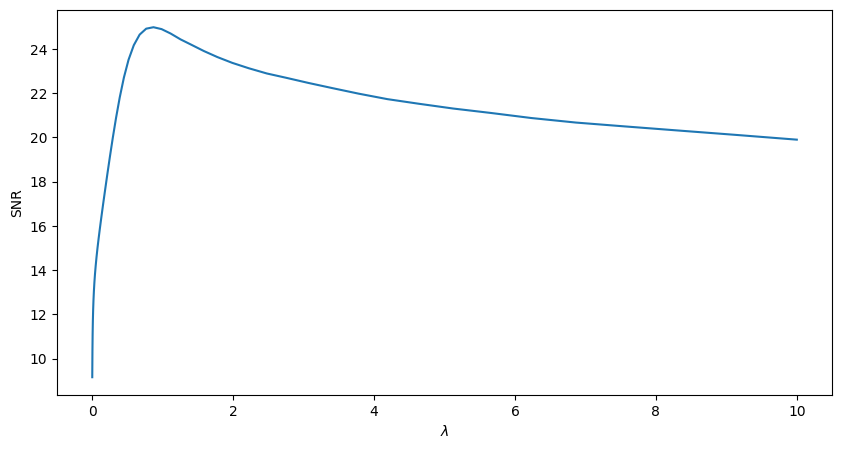

Best Lambda according to SSIM: 0.8697364899104376


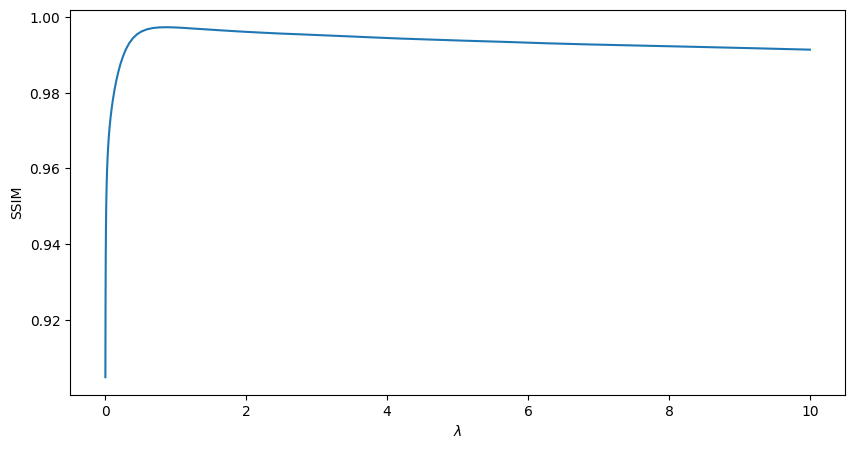

In [25]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

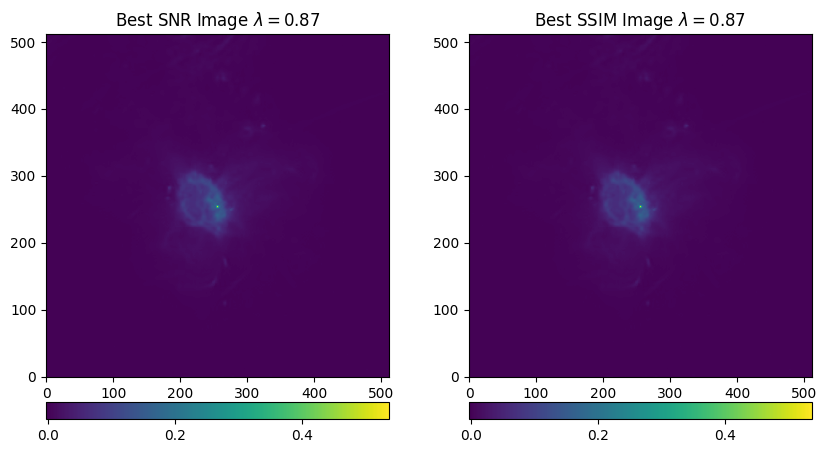

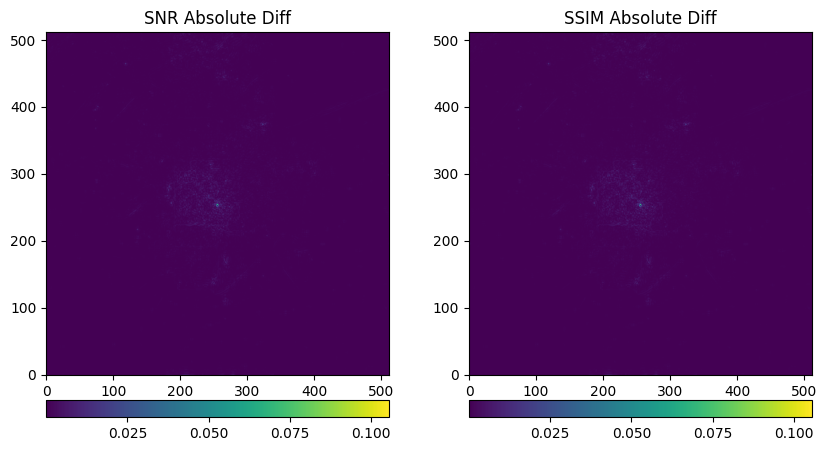

In [26]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 8: SGR B2 multi-step

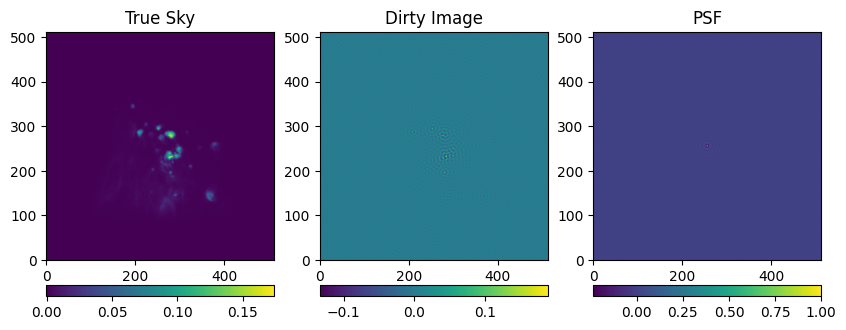

In [27]:
dirty = helpers.readFits("lambda_tests/SGRB_long_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRB_long_psf.fits")
gt = helpers.readFits("lambda_tests/SGRB_full_gt.fits")
lowres = helpers.readFits("lambda_tests/SGRB_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRB_multistep/"

Best Lambda: 0.15519946863999382


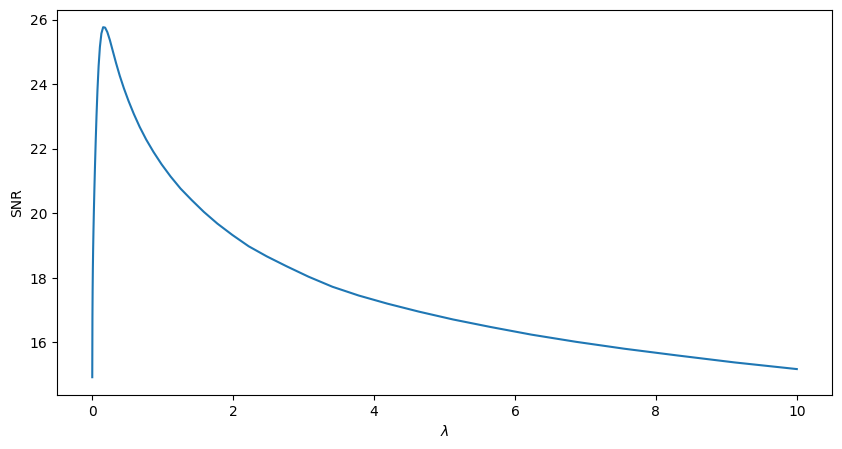

Best Lambda according to SSIM: 0.15519946863999382


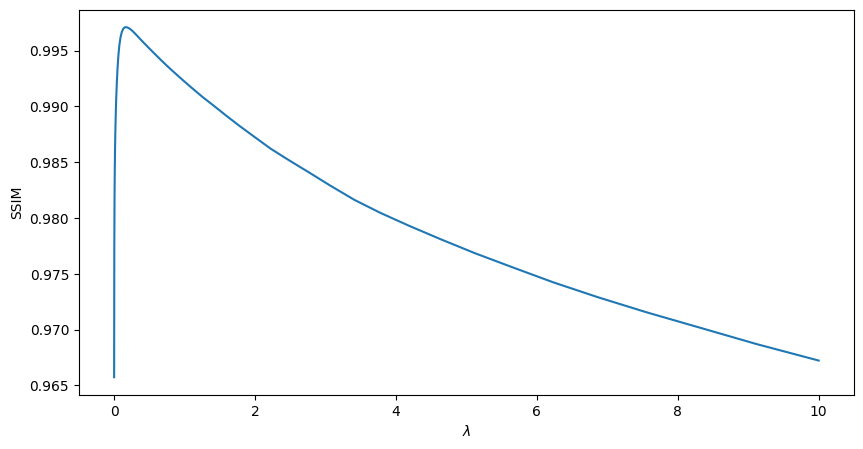

In [28]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

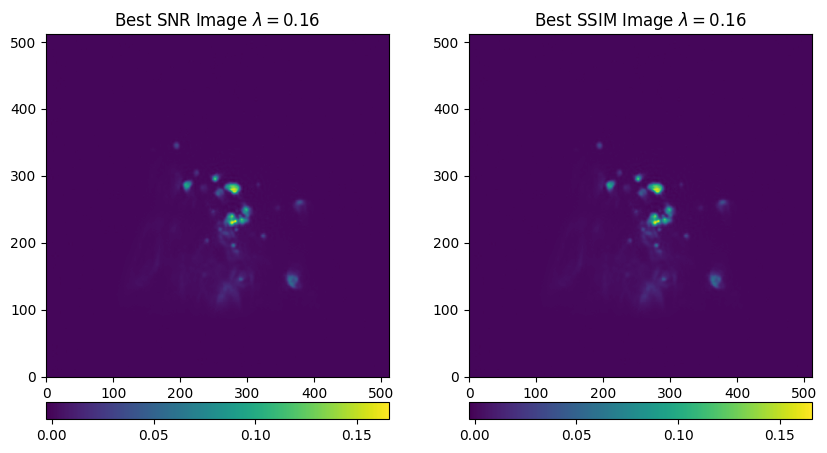

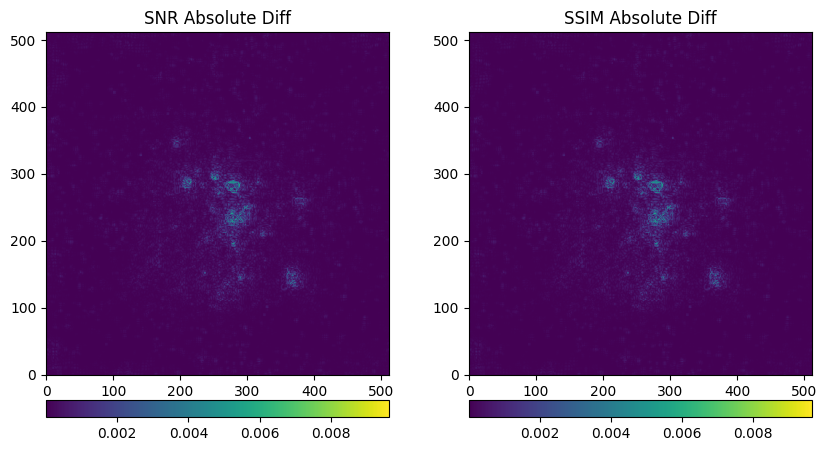

In [29]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 9: SGR C multi-step

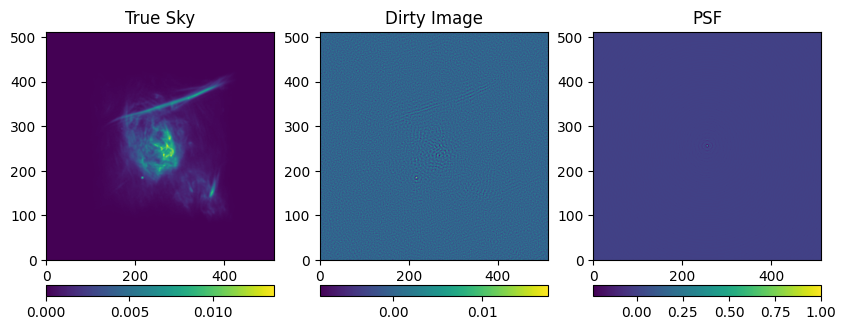

In [30]:
dirty = helpers.readFits("lambda_tests/SGRC_long_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRC_long_psf.fits")
gt = helpers.readFits("lambda_tests/SGRC_full_gt.fits")
lowres = helpers.readFits("lambda_tests/SGRC_short_gt.fits")

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRC_multistep/"

Best Lambda: 0.09111540170883178


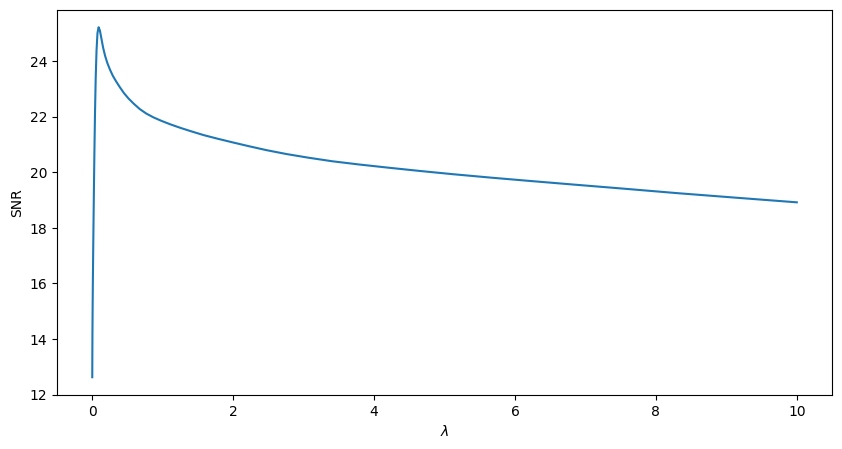

Best Lambda according to SSIM: 0.09111540170883178


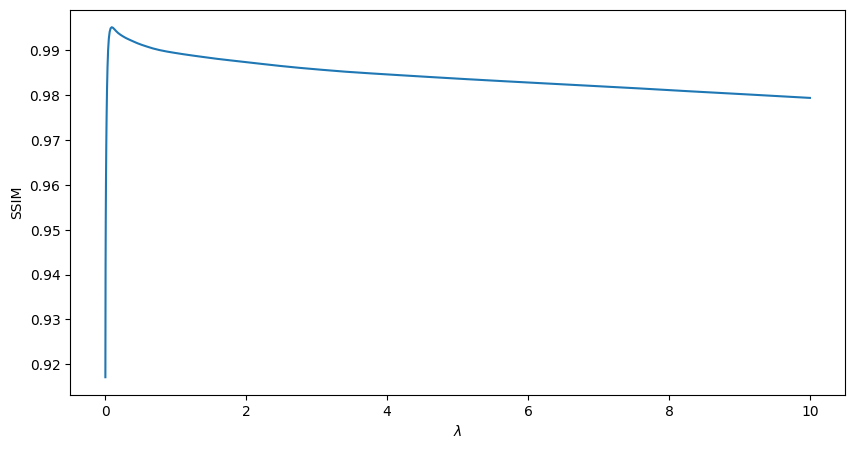

In [31]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

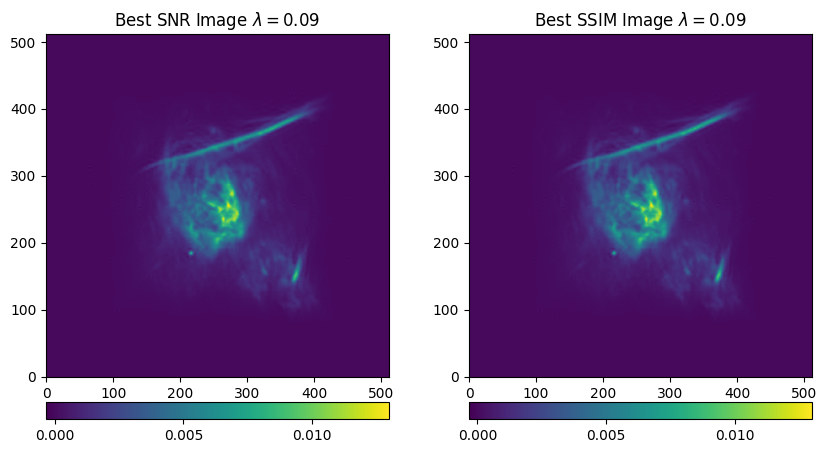

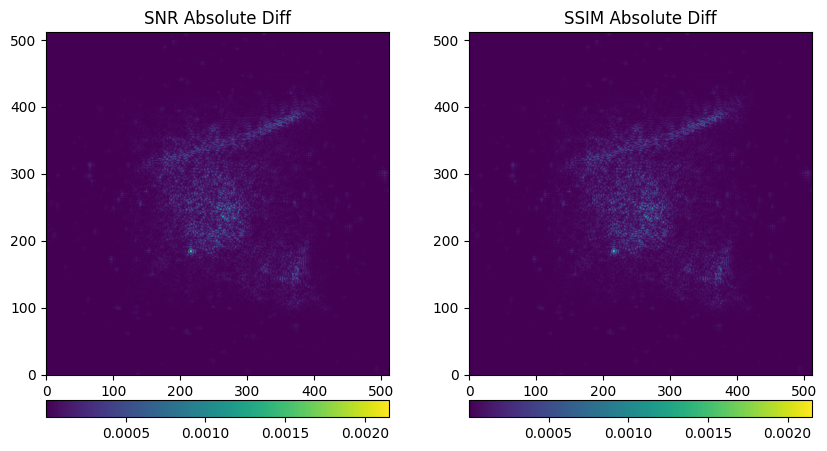

In [32]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 10: SGR A first residual

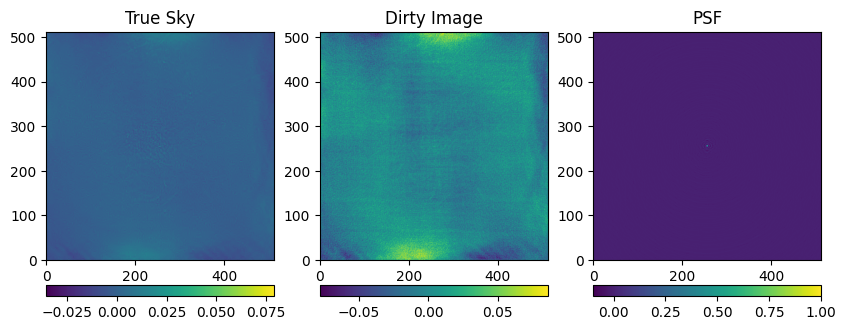

In [33]:
dirty = helpers.readFits("lambda_tests/SGRA_firstresid_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRA_full_psf.fits")
sky = helpers.readFits("lambda_tests/SGRA_full_gt.fits")
prev_deconv = helpers.readFits("lambda_tests/SGRA_firstresid_deconv.fits")
gt = sky - prev_deconv

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRA_firstresid/"

Best Lambda: 1.584893192461114


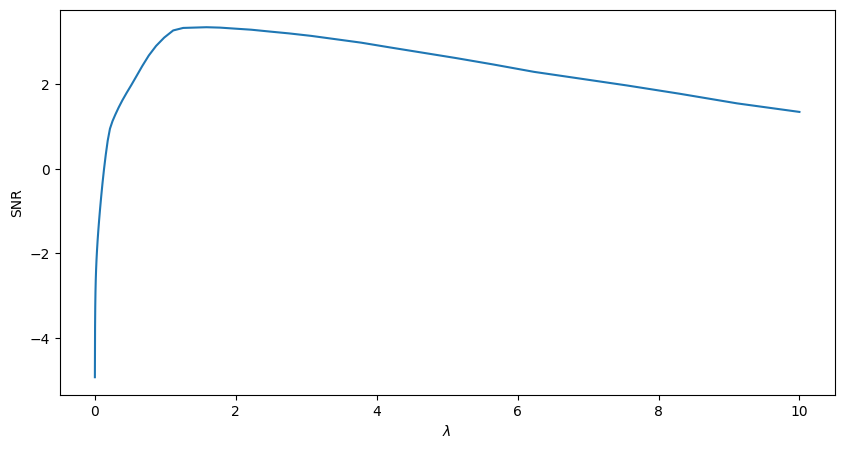

Best Lambda according to SSIM: 0.001


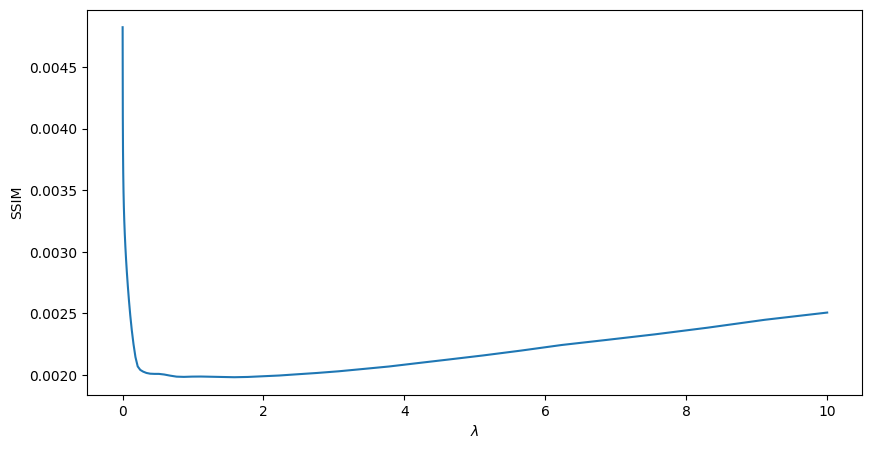

In [34]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

In [35]:
besti = 
helpers.plotNImages([lowres, gt], [])

SyntaxError: invalid syntax (2803712218.py, line 1)

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 11: SGR A second residual

In [ ]:
dirty = helpers.readFits("lambda_tests/SGRA_secondresid_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRA_full_psf.fits")
sky = helpers.readFits("lambda_tests/SGRA_full_gt.fits")
deconv1 = helpers.readFits("lambda_tests/SGRA_firstresid_deconv.fits")
deconv2 = helpers.readFits("lambda_tests/SGRA_secondresid_deconv.fits")
gt = sky - deconv1 - deconv2

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRA_secondresid/"

In [ ]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 12: SGR B2 first residual

In [ ]:
dirty = helpers.readFits("lambda_tests/SGRB_firstresid_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRB_full_psf.fits")
sky = helpers.readFits("lambda_tests/SGRB_full_gt.fits")
prev_deconv = helpers.readFits("lambda_tests/SGRB_firstresid_deconv.fits")
gt = sky - prev_deconv

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRB_firstresid/"

In [ ]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 13: SGR B2 second residual

In [ ]:
dirty = helpers.readFits("lambda_tests/SGRB_secondresid_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRB_full_psf.fits")
sky = helpers.readFits("lambda_tests/SGRB_full_gt.fits")
deconv1 = helpers.readFits("lambda_tests/SGRB_firstresid_deconv.fits")
deconv2 = helpers.readFits("lambda_tests/SGRB_secondresid_deconv.fits")
gt = sky - deconv1 - deconv2

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRB_secondresid/"

In [ ]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 14: SGR C first residual

In [ ]:
dirty = helpers.readFits("lambda_tests/SGRC_firstresid_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRC_full_psf.fits")
sky = helpers.readFits("lambda_tests/SGRC_full_gt.fits")
prev_deconv = helpers.readFits("lambda_tests/SGRC_firstresid_deconv.fits")
gt = sky - prev_deconv

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRC_firstresid/"

In [ ]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)

## Test case 15: SGR C second residual

In [ ]:
dirty = helpers.readFits("lambda_tests/SGRC_secondresid_dirty.fits")
psf = helpers.readFits("lambda_tests/SGRC_full_psf.fits")
sky = helpers.readFits("lambda_tests/SGRC_full_gt.fits")
deconv1 = helpers.readFits("lambda_tests/SGRC_firstresid_deconv.fits")
deconv2 = helpers.readFits("lambda_tests/SGRC_secondresid_deconv.fits")
gt = sky - deconv1 - deconv2

helpers.plotGDP(gt, dirty, psf, cmap)

path = "results/lambda_results/SGRC_secondresid/"

In [ ]:
snrs = helpers.read_csv(path + "snr.dat")
snrs = [float(x) for x in snrs]
max_snr_idx = numpy.argmax(snrs)
print("Best Lambda: " + str(lambdas[max_snr_idx]))
helpers.plot1D(lambdas, snrs, "$\lambda$", "SNR")

ssims = helpers.read_csv(path + "ssim.dat")
ssims = [float(x) for x in ssims]
max_ssim_idx = numpy.argmax(ssims)
print("Best Lambda according to SSIM: " + str(lambdas[max_ssim_idx]))
helpers.plot1D(lambdas, ssims, "$\lambda$", "SSIM")

In [ ]:
helpers.plotSNRvsSSIM(lambdas, path, max_snr_idx, max_ssim_idx, gt, cmap)